In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

### Load all necessary packages

In [2]:
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

from rpy2.robjects import numpy2ri, pandas2ri

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

import rpy2.robjects.lib.ggplot2 as gp
from rpy2.ipython.ggplot import image_png

from rpy2.rinterface_lib import openrlib

robjects.r('''

## add the full path to folder inside which MetENP R package is installed; relative path may not work

.libPaths( c( .libPaths(), "/home/mano/.local/R" ))

##.libPaths( c( .libPaths(), "/var/www/html/appyters/MetENP/R" ))

print(.libPaths())
''')
;

[1] "/usr/lib64/R/library" "/usr/share/R/library" "/home/mano/.local/R" 


''

In [3]:
%%appyter hide_code 

import pandas as pd
from io import StringIO


_formatter = robjects.r('''
install.packages("dplyr")
function (X) {
  return (
    format_tsv(
      as.data.frame(apply(X, c(1,2), function(x) {
        unlist(x, TRUE, TRUE)
      }))
    )
  )
}
''')
def as_df(data, index_col=None):
    return pd.read_csv(StringIO(_formatter(data)[0]), sep='\t', index_col=index_col)

```python
import pandas as pd
from io import StringIO
_formatter = robjects.r('''
install.packages("dplyr")
function (X) {
  return (
    format_tsv(
      as.data.frame(apply(X, c(1,2), function(x) {
        unlist(x, TRUE, TRUE)
      }))
    )
  )
}
''')
def as_df(data, index_col=None):
    return pd.read_csv(StringIO(_formatter(data)[0]), sep='\t', index_col=index_col)
```

In [4]:
from rpy2.robjects.packages import importr
metenp = importr('MetENP')

In [5]:
%%appyter hide_code
{% do SectionField(
    name='INPUT',
    title='Input the Study, Factors and Analysis type Information',
    subtitle='Specify your study here',
    img='upload_icon.png',
)%}
{% do SectionField(
    name='SIGM',
    title='Find Significant Metabolites',
    subtitle='Run significance of all the analysis summary together',
    img='vol.png',
)%}
{% do SectionField(
    name='COUNTCLASS',
    title='Count Metabolites by Class',
    subtitle='Count the metabolites of each class',
    img='bar.png',
)%}
{% do SectionField(
    name='ENRICH',
    title='Enrichment Score by Class',
    subtitle='Calculate the enrichment score of each metabolite class',
    img='enrich.png',
)%}
{% do SectionField(
    name='HEAT',
    title='Heatmap',
    subtitle='Heatmap of metabolites x enriched pathways',
    img='heat.png',
)%}
{% do SectionField(
    name='DOT',
    title='Dotplot',
    subtitle='Plot a dotplot of enrichment by class',
    img='dot.png',
)%}


In [6]:
%%appyter code_exec

{% set study = MetabolomicsStudyField(
    name='study',
    label='Study Information',
    description = "Resolve the factors and analysis type for the study",
    default={'study_id': 'ST000915', 'fac1': 'Cirrhosis', 'fac2': 'Normal', 'anal': 'Core G Fatty acids/Eicosanoids', 'faccol': 'Diagnosis' },
    section='INPUT',
) 

%}

print("Study ID:", {{study.value.study_id|jsonify}})


```python

print("Study ID:", "ST000915")
```

Study ID: ST000915


In [7]:
%%appyter hide_code 

{% set studyOrg = StringField(name='studyOrg', label='KEGG Organism Code', description = "hsa for human, mmu for mouse, eco for E. coli, rno for rat. See https://www.genome.jp/kegg/catalog/org_list.html for all organisms", default='hsa', section='INPUT') %}

In [8]:
%%appyter hide_code

{% set classtype = MultiChoiceField(
    name='classtype',
    label='Choose a Metabolite Class',
    description='Choose between sub_class, main_class and super_class',
    default=[
        'sub_class',
    ],
    choices=[
        'sub_class',
        'main_class',
        'super_class',
    ],
    section='INPUT'
) %}

### Start data processing

### Gets metabolomics data, metadata and metabolite info from Metabolomics Workbench using REST service

In [9]:
%%appyter code_exec

data_1 = robjects.r['getmwstudies']({{study.value.study_id|jsonify}}, 
    'data'
)

```python
data_1 = robjects.r['getmwstudies']("ST000915",
    'data'
)
```

In [10]:
%%appyter hide_code

data_1 = metenp.getmwstudies({{study.value.study_id|jsonify}}, 'data')
as_df(data_1, index_col=[0, 1, 2, 3, 4])

```python
data_1 = metenp.getmwstudies("ST000915", 'data')
as_df(data_1, index_col=[0, 1, 2, 3, 4])
```

In [11]:
with openrlib.rlock:
    
    robjects.r.assign('data_1', data_1)
    
    robjects.r('''

    data_1_print = data.frame(apply(data_1, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
    head(data_1_print)

    ''')
    
    pass

### Gets metabolomics data, metadata and metabolite info from Metabolomics Workbench using REST service

In [12]:
%%appyter code_exec

metadata = robjects.r['getmwstudies']({{study.value.study_id|jsonify}}, 
    'factors'
)


```python
metadata = robjects.r['getmwstudies']("ST000915",
    'factors'
)
```

In [13]:
robjects.r.assign('metadata', metadata)

robjects.r('''
metadata_print = data.frame(apply(metadata, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
head(metadata_print)
''')

,,study_id,local_sample_id,subject_type,factors,Diagnosis
0,1,ST000915,NASH005,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
1,2,ST000915,NASH007,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
2,3,ST000915,NASH009,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
3,4,ST000915,NASH013,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
4,5,ST000915,NASH016,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
5,6,ST000915,NASH022,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis


### Associate metabolomics data to the refmet class

In [14]:
refmet_class = robjects.r['convert_refmet'](data_1)

robjects.r.assign('refmet_class', refmet_class)

robjects.r('''

refmet_class_print = data.frame(apply(refmet_class, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
head(refmet_class_print)

''')

,,metabolite_name,analysis_id,analysis_summary,metabolite_id,...,main_class,sub_class
0,1,"1,2-DG(30:0)",AN001488,Core E Neutral Lipids,ME231190,...,Diradylglycerols,DAG
1,2,"1,2-DG(30:1)",AN001488,Core E Neutral Lipids,ME231189,...,Diradylglycerols,DAG
2,3,"1,2-DG(32:0)",AN001488,Core E Neutral Lipids,ME231196,...,Diradylglycerols,DAG
3,4,"1,2-DG(32:1)",AN001488,Core E Neutral Lipids,ME231195,...,Diradylglycerols,DAG
4,5,"1,2-DG(32:2)",AN001488,Core E Neutral Lipids,ME231194,...,Diradylglycerols,DAG
5,6,"1,2-DG(32:3)",AN001488,Core E Neutral Lipids,ME231193,...,Diradylglycerols,DAG


### This lists each unique metadata factor/independent variable

In [15]:
robjects.r('''
study_facs = data.frame(unique(metadata_print$factors))
''')

,,unique.metadata_print.factors.
0,1,Diagnosis:Cirrhosis
1,2,Diagnosis:NASH
2,3,Diagnosis:Normal
3,4,Diagnosis:Steatosis


### This lists each different analysis terms

In [16]:
robjects.r('''
study_anals = data.frame(unique(data_1_print$analysis_summary))
''')

,,unique.data_1_print.analysis_summary.
0,1,Core G Fatty acids/Eicosanoids
1,2,Core J Sterols
2,3,Core K Prenols/Cardiolipins
3,4,Core E Neutral Lipids
4,5,Core I Sphingolipids
5,6,Core H Phospholipids


### Here, find significant metabolites and the significance of all the analysis summary together. The analysis summary/modes you got in the previous section.

In [17]:
%%appyter hide_code

 
   






In [18]:
%%appyter hide_code

{% set normtype = MultiChoiceField(
    name='normtype',
    label='Select Type of Normalization. How would you like to handle missing data?',
    description='Select 1. half_of_min: where the NAs are replaced by half of min values in the data, 2. remove_NAs: where Cols with NAs values are removed, or 3. 50percent: where cols with more than 50% NAs values are removed. half_of_min is ideal when you wish to see which metabolites were present in either group. Very high fold change would mean it was present in either group.',
    default=[
        '50percent',
    ],
    choices=[
        'half_of_min',
        'remove_NAs',
        '50percent',
    ],
    section='SIGM'
) %}


In [19]:
%%appyter hide_code

{% set pthres = MultiChoiceField(
    name='pthres',
    label='P-Value Threshhold',
    description='P-Value Threshhold for Volcano Plot. Float between 0 and 1.',
    default=[
        '0.05',
    ],
    choices=[
        '0.001',
        '0.002',
        '0.005',
        '0.01',
        '0.02',
        '0.05',
        '0.10'
    ],
    section='SIGM'
) %}


In [20]:
%%appyter hide_code

#0.0, 0.5, 0.6, 0.8, 1, 1.2, 1.5, 2, 2.5, 3
#TODO - don't do yet 

{% set thres_log2foldchange = StringField(
    name = 'tres_log2foldchange',
    label = 'Log2FoldChange Threshhold',
    description= "Log2FoldChange Threshhold for Volcano Plot.",
    default='0.5',
    section='SIGM'
) %}


```python
#0.0, 0.5, 0.6, 0.8, 1, 1.2, 1.5, 2, 2.5, 3
#TODO - don't do yet
```

In [21]:
%%appyter hide_code

{% set padj = MultiChoiceField(
    name='padj',
    label='Select P Adjust Method',
    description='P adjust method for significance analysis of metabolites',
    default=[
        'fdr',
    ],
    choices=[
        'fdr',
        'BH',
        'holm',
        'bonferroni',
        'hochberg',
        'hommel',
    ],
    section='SIGM'
) %}

In [22]:
%%appyter code_eval

robjects.r.assign('refmet_class', refmet_class)
robjects.r.assign('metcol', 'metabolite_name')
robjects.r.assign('fac1', {{study.value.fac1|jsonify}})
robjects.r.assign('fac2', {{study.value.fac2|jsonify}})
robjects.r.assign('faccol', {{study.value.faccol|jsonify}})
robjects.r.assign('samcol', 'local_sample_id')
robjects.r.assign('normtype', {{normtype}})
robjects.r.assign('pthres', {{pthres}})
robjects.r.assign('thres_log2foldchangevar', {{thres_log2foldchange}})
robjects.r.assign('padj', {{padj}})

```python
robjects.r.assign('refmet_class', refmet_class)
robjects.r.assign('metcol', 'metabolite_name')
robjects.r.assign('fac1', "Cirrhosis")
robjects.r.assign('fac2', "Normal")
robjects.r.assign('faccol', "Diagnosis")
robjects.r.assign('samcol', 'local_sample_id')
robjects.r.assign('normtype', ['50percent'])
robjects.r.assign('pthres', ['0.05'])
robjects.r.assign('thres_log2foldchangevar', '0.5')
robjects.r.assign('padj', ['fdr'])
```

0,"[1] ""fdr"""


In [23]:
robjects.r('''
ptreshnum<-as.numeric(pthres)
thres_log2foldchangenum<-as.numeric(thres_log2foldchangevar)
padjchar<-as.character(padj[1])
''')
;

''

In [24]:
%%appyter code_exec

robjects.r.assign('anal',{{study.value.anal|jsonify}} )



```python

robjects.r.assign('anal',"Core G Fatty acids/Eicosanoids" )
```

### Find the log2fold change and p value on metabolomics data using a t-test. 

In [25]:
robjects.r('''
analysis_type_sep = "___";
anal_vec = trimws(unlist(strsplit(anal, analysis_type_sep)))
print(anal_vec)
stats_metabolites = significant_met(metabolomics_data=refmet_class_print, met_col='metabolite_name',analysis_type=anal_vec, metadata=metadata, factor1=fac1, factor2=fac2, factor_col=faccol,sample_col='local_sample_id', p_adjust=padjchar,normalization=normtype)
''')
;

[1] "Core G Fatty acids/Eicosanoids"


''

In [26]:
robjects.r('''
sig_metabolites = stats_metabolites[which(stats_metabolites[,"pval"] <= ptreshnum&abs(stats_metabolites[,"log2Fold_change"])>thres_log2foldchangenum),]
''')
;

''

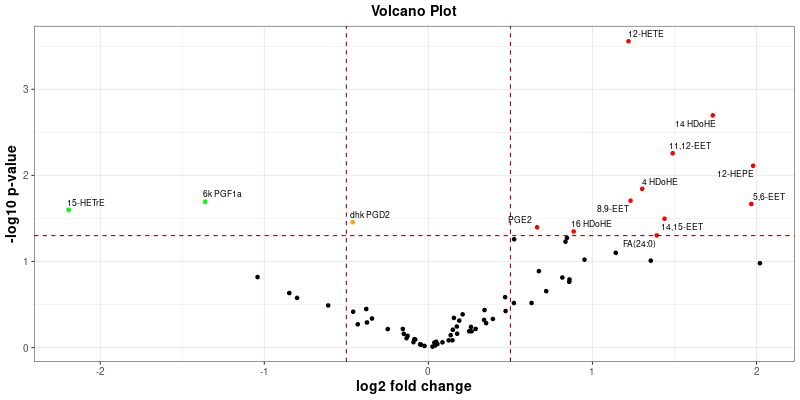

In [27]:
image_png(robjects.r('''
plot_volcano(stats_metabolites, thres_pval= ptreshnum, thres_log2foldchange = thres_log2foldchangenum, TRUE)
'''))

Each color describes a different metabolite group.

### Map metabolite class of the significant metabolites utilzing refmet classification in Metabolomics Workbench
This function not only maps metabolite to metabolite class but also to external databases such as pubchem, inchi key, smiles, and KEGG (if you chose to add in KEGG).

In [28]:
with openrlib.rlock:
    robjects.r('''
    sig_metabolites_kegg_id= map_keggid(sig_metabolites)
    ''')
    pass

#### Check all your significant metabolites have not been assigned metabolite class
Outcome should be 0 elements.

In [29]:
robjects.r('''
setdiff(sig_metabolites$refmet_name, sig_metabolites_kegg_id$refmet_name)
''')

<rpy2.robjects.vectors.StrVector object at 0x7f5795ab8c80> [RTYPES.STRSXP]
R classes: ('character',)
[]

### Count the number of metabolites in each of the metabolite classes and plot them with a bar graph

In [30]:
%%appyter hide_code

{% set thres_log2foldchange_countclass = StringField(
    name = 'thres_log2foldchange_countclass',
    label = 'Log2FoldChange Threshhold for counting',
    description= "Log2FoldChange Threshhold for counting a metabolite in a class. Float between 0 and 1.",
    default='0.5',
    section='COUNTCLASS'
) %}

In [31]:
%%appyter code_exec

robjects.r.assign('classtype', {{classtype}})

robjects.r.assign('thres_log2foldchange_countclass', {{thres_log2foldchange_countclass}})

robjects.r('''
metclassvar <- as.character(classtype[1])
count_changes = metcountplot(df_metclass=sig_metabolites_kegg_id, metclass=metclassvar, plotting=TRUE, thres_logfC = thres_log2foldchange_countclass)
''')

```python
robjects.r.assign('classtype', ['sub_class'])
robjects.r.assign('thres_log2foldchange_countclass', '0.5')
robjects.r('''
metclassvar <- as.character(classtype[1])
count_changes = metcountplot(df_metclass=sig_metabolites_kegg_id, metclass=metclassvar, plotting=TRUE, thres_logfC = thres_log2foldchange_countclass)
''')
```

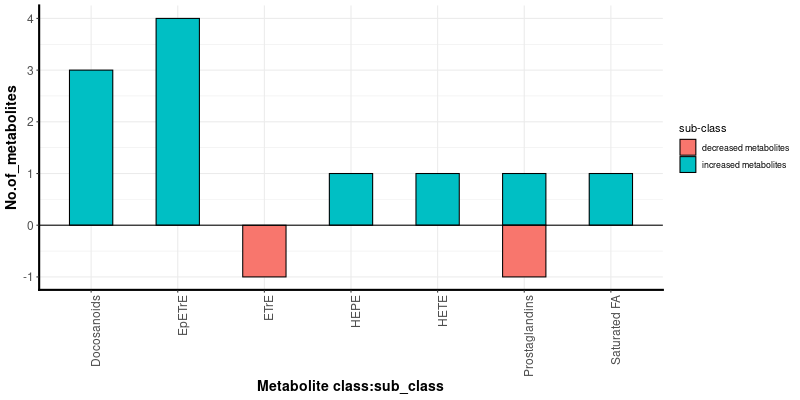

In [32]:
image_png(robjects.r('''
count_changes$plotimg
'''))

### Enrichment score (p-value) for metabolite classes

Calculate the enrichment score (p-value) of each metabolite class. 

Enrichment score (p-value) is calculated through the hypergeometric method as described by Choudhary et al. [https://www.biorxiv.org/content/10.1101/2020.11.20.391912v1].

In [33]:
%%appyter hide_code

{% set sigmets = IntField(
    name = 'sigmets',
    label = 'Minimum # of (most significant) metabolites needed in a class to include the class in enrichment.',
    description= "We advise to use the number of metabolites in each class as 3 or more. However, if you want to know the enrichment score for all the metabolites, choose 1.",
    default=3,
    section = 'ENRICH'
) %}

In [34]:
%%appyter code_eval
robjects.r.assign('sigmets', {{sigmets}})

```python

robjects.r.assign('sigmets', 3)
```

3


In [35]:
robjects.r('''
metenrichment = metclassenrichment(df_metclass=sig_metabolites_kegg_id,refmet_class, metclass=metclassvar,enrich_stats="HG",no=sigmets)
''')
;

''

## Plot the enrichment score (p-value) via function plot_met_enrichment

### If no figure shows here, or an error returns, this means no classes had enough significant metabolites. Decrease the minimum number of significant metabolites per class needed and reload/rerun the appyter program.

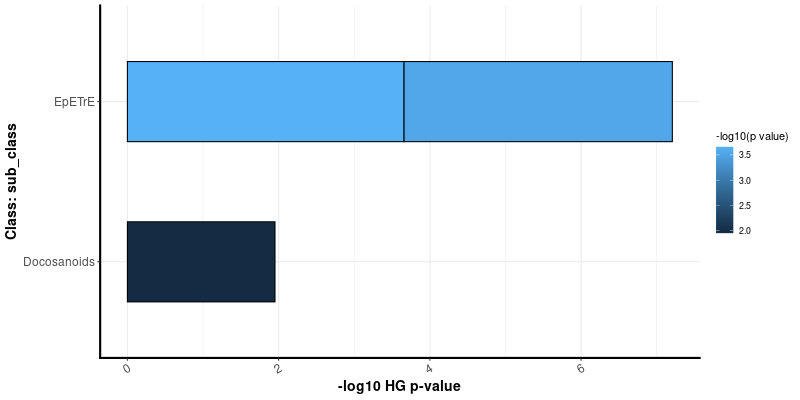

In [36]:
image_png(robjects.r('''
plot_met_enrichment(metenrichment, metclassvar,"HG", no=sigmets)
'''))

### Check the pathways with reactions involving the significant metabolites

In [37]:
%%appyter code_exec

robjects.r.assign('studyOrg', {{studyOrg}})

robjects.r('''
met_path = met_pathways(df_metenrichment = metenrichment, studyOrg)
head(met_path)
''')

```python
robjects.r.assign('studyOrg', 'hsa')
robjects.r('''
met_path = met_pathways(df_metenrichment = metenrichment, studyOrg)
head(met_path)
''')
```

[1] "res is not null"


### Get pathway enrichment score (p-value).

Once we have the pathway information, we can calculate enrichment score (p-value) of pathways using the hypergeometric scores for each pathway.

For hypergeometric score, we need to know the total number of KEGG compounds that are linked to KEGG pathways. 

N = Total no. of compounds linked to KEGG pathway, 
L = No. of compounds in a pathway, 
M = No. of altered (significant) compounds in a pathway, 
K = Total no. of altered (significant) compounds. 
Then, 
score or p-value = phyper(M-1, L, N-L, K)

This function also utilizes korg dataset from pathview package.

In [38]:
%%appyter hide_code

{% set keggTF = MultiChoiceField(
    name='keggTF',
    label='Analysis with KEGG',
    description='Would you like the enrichment analysis to include all KEGG pathways?',
    default=[
        'FALSE',
    ],
    choices=[
        'TRUE',
        'FALSE'
    ],
    section='ENRICH'
) %}

In [39]:
%%appyter code_exec

robjects.r.assign('keggTF', {{keggTF}})

robjects.r('''
keggTFchar<-as.character(keggTF[1])
''')

```python
robjects.r.assign('keggTF', ['FALSE'])
robjects.r('''
keggTFchar<-as.character(keggTF[1])
''')
```

In [43]:
%%appyter code_exec

# relative paths do not work, exclude the starting / as it gets added automatically when appyter runs
#korgvar = "{{ url_for('home/sumana/appyters/MetENP/static', filename='korg.RData') }}"
#ls_pathvar = "{{ url_for('home/sumana/appyters/MetENP/static', filename='ls_path.RData') }}"

korgvar = "{{ url_for('var/www/html/appyters/MetENP/static', filename='korg.RData') }}"
ls_pathvar = "{{ url_for('var/www/html/appyters/MetENP/static', filename='ls_path.RData') }}"

robjects.r.assign('korgvar', korgvar)
robjects.r.assign('ls_pathvar', ls_pathvar)

```python
# relative paths do not work, exclude the starting / as it gets added automatically when appyter runs
#korgvar = "home/sumana/appyters/MetENP/static/korg.RData"
#ls_pathvar = "home/sumana/appyters/MetENP/static/ls_path.RData"
korgvar = "var/www/html/appyters/MetENP/static/korg.RData"
ls_pathvar = "var/www/html/appyters/MetENP/static/ls_path.RData"
robjects.r.assign('korgvar', korgvar)
robjects.r.assign('ls_pathvar', ls_pathvar)
```

In [41]:
robjects.r('''
load(korgvar)
load(ls_pathvar)
''')

R[write to console]: Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection

R[write to console]: In addition: 
R[write to console]: There were 11 warnings (use warnings() to see them)
R[write to console]: 



RRuntimeError: Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection


In [168]:
robjects.r('''
kegg_es = path_enrichmentscore(met_path,sig_metabolite_kegg_id=sig_metabolite_kegg_id,ls_path=ls_path,refmet_class=refmet_class,sps=studyOrg,padj=padjchar, kegg_comp_path=keggTFchar)
head(kegg_es)
''')

,,Pathway name,No.of mets in study,Total_no._of_comps_in_pathway,pathway_HG p-value,Padjust
0,1,Arachidonic acid metabolism,4,75,0.09097962231469853,0.09097962231469853


### Plot pathway network
Only plotting significant pathways (pathways with >= the minimum number significant metabolites). There is no p-value or adjusted p-value threshold applied for the pathways.

The pathway network is such that it shows metabolites that are connected to different pathways and same metabolite in different pathway. Color of nodes of metabolites are according to the fold change of metabolites (low expression in green and high in red) and size of pathway nodes (square nodes) are according to the number of branches (meaning no of metabolites). All metabolite are written in blue.

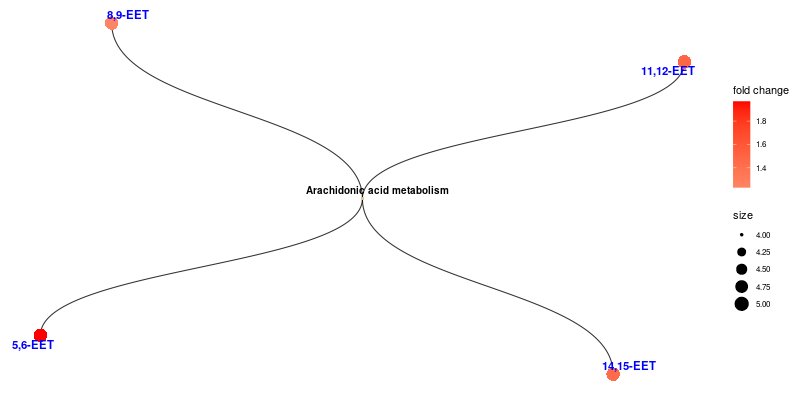

In [169]:
image_png(robjects.r('''
plot_pathway_networks (met_path,kegg_es, TRUE)
'''))

### Heatmap

In [170]:
%%appyter hide_code

{% set x_size_heat = IntField(
    name = 'x_size_heat',
    label = 'Font Size for X',
    description= "To change the size of the heatmap",
    default=8,
    section = 'HEAT'
) %}

In [171]:
%%appyter hide_code

{% set y_size_heat = IntField(
    name = 'y_size_heat',
    label = 'Font Size for Y',
    description= "To change the size of the heatmap",
    default=6,
    section = 'HEAT'
) %}

In [172]:
%%appyter code_exec

robjects.r.assign('x_size_heat', {{x_size_heat}})
robjects.r.assign('y_size_heat', {{y_size_heat}})

```python
robjects.r.assign('x_size_heat', 8)
robjects.r.assign('y_size_heat', 6)
```

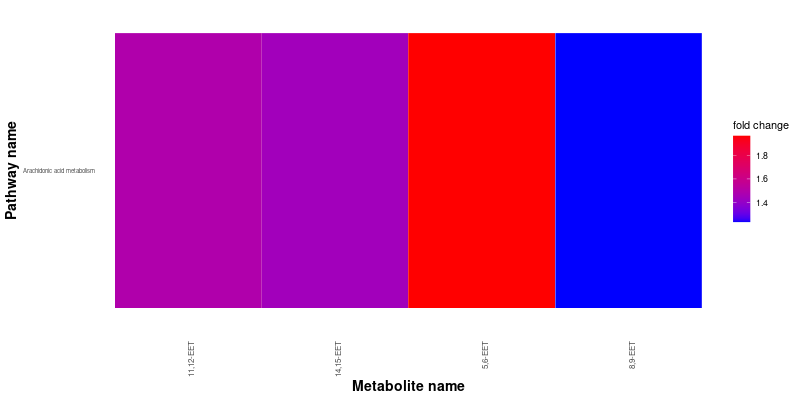

In [173]:
image_png(robjects.r('''
plot_heatmap(met_path, shorten_name=TRUE,refmet_name=FALSE, xaxis=x_size_heat, yaxis=y_size_heat)
'''))

### Dotplot

In [174]:
%%appyter hide_code

{% set x_size_dot = IntField(
    name = 'x_size_dot',
    label = 'Font Size for X',
    description= "To change the size of the dotplot",
    default=8,
    section = 'DOT'
) %}

In [175]:
%%appyter hide_code

{% set y_size_dot = IntField(
    name = 'y_size_dot',
    label = 'Font Size for Y',
    description= "To change the size of the dotplot",
    default=6,
    section = 'DOT'
) %}

In [176]:
%%appyter code_exec

robjects.r.assign('x_size_dot', {{x_size_dot}})
robjects.r.assign('y_size_dot', {{y_size_dot}})

```python
robjects.r.assign('x_size_dot', 8)
robjects.r.assign('y_size_dot', 6)
```

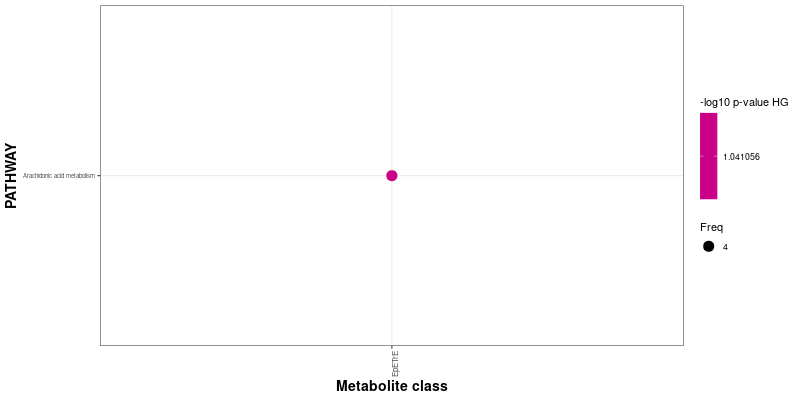

In [177]:
image_png(robjects.r('''
dotplot_met_class_path (met_path, kegg_es, metclassvar,xaxis=x_size_dot,yaxis=y_size_dot)
'''))

### Get the gene and enzyme info

Here we get the information of genes involved in enriched pathways for specified organism using KEGG database.

In [178]:
robjects.r('''
met_gene_info = enzyme_gene_info (metenrichment, studyOrg, metclassvar)
head(met_gene_info)
''')

,,orthology_id,ORTHOLOGY,gene_id,gene_name,...,EQUATION_more,ENZYME
0,1,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""Arachidonate + Oxygen + NADPH + H+ <=> 11,12-EET + NADP+ + H2O""","[1] ""1.14.14.1"" ""1.14.14.-"""
1,2,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""Arachidonate + Oxygen + NADPH + H+ <=> 14,15-EET + NADP+ + H2O""","[1] ""1.14.14.1"" ""1.14.14.-"""
2,3,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""Arachidonate + Oxygen + NADPH + H+ <=> 8,9-EET + NADP+ + H2O""","[1] ""1.14.14.1"" ""1.14.14.-"""
3,4,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""Arachidonate + Oxygen + NADPH + H+ <=> 5,6-EET + NADP+ + H2O""","[1] ""1.14.14.1"" ""1.14.14.-"""
4,5,K08726,soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76],"CDS ""2053""","[1] ""(RefSeq) epoxide hydrolase 2""",...,"[1] ""14,15-EET + H2O <=> 14,15-DHET""","[1] ""3.3.2.10"""
5,6,K08726,soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76],"CDS ""2053""","[1] ""(RefSeq) epoxide hydrolase 2""",...,"[1] ""11,12-EET + H2O <=> 11,12-DHET""","[1] ""3.3.2.10"""


#### Get the information if metabolite is a reactant or substrate

In [179]:
robjects.r('''
rclass_info = react_substrate(met_gene_info)
head(rclass_info)
''')

,,orthology_id,ORTHOLOGY,gene_id,gene_name,...,ENZYME,reactant_product
0,1,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""1.14.14.1"" ""1.14.14.-""",Product
1,2,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""1.14.14.1"" ""1.14.14.-""",Product
2,3,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""1.14.14.1"" ""1.14.14.-""",Product
3,4,K07418,cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75],"CDS ""1573""","[1] ""(RefSeq) cytochrome P450 family 2 subfamily J member 2""",...,"[1] ""1.14.14.1"" ""1.14.14.-""",Product
4,5,K08726,soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76],"CDS ""2053""","[1] ""(RefSeq) epoxide hydrolase 2""",...,"[1] ""3.3.2.10""",Substrate
5,6,K08726,soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76],"CDS ""2053""","[1] ""(RefSeq) epoxide hydrolase 2""",...,"[1] ""3.3.2.10""",Substrate


#### Get gene info in short form

In [180]:
robjects.r('''
met_gene_info2=data.table::data.table(rclass_info)[,lapply(.SD, function(x) toString(unique(x))), by = 'Metabolite']
''')

,,Metabolite,orthology_id,ORTHOLOGY,gene_id,...,ENZYME,reactant_product
0,1,"11,12-EET","K07418, K08726, K17709, K17718, K17719","cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75], soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76], cytochrome P450 family 2 subfamily B6 [EC:1.14.14.-], cytochrome P450 family 2 subfamily C8 [EC:1.14.14.1], cytochrome P450 family 2 subfamily C9 [EC:1.14.14.51 1.14.14.52 1.14.14.53 1.14.14.-]","1573, 2053, 1555, 1558, 1559",...,"c(""1.14.14.1"", ""1.14.14.-""), 3.3.2.10","Product, Substrate"
1,2,"14,15-EET","K07418, K08726, K17709, K17718, K17719","cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75], soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76], cytochrome P450 family 2 subfamily B6 [EC:1.14.14.-], cytochrome P450 family 2 subfamily C8 [EC:1.14.14.1], cytochrome P450 family 2 subfamily C9 [EC:1.14.14.51 1.14.14.52 1.14.14.53 1.14.14.-]","1573, 2053, 1555, 1558, 1559",...,"c(""1.14.14.1"", ""1.14.14.-""), 3.3.2.10","Product, Substrate"
2,3,"8,9-EET","K07418, K08726, K17709, K17719","cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75], soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76], cytochrome P450 family 2 subfamily B6 [EC:1.14.14.-], cytochrome P450 family 2 subfamily C9 [EC:1.14.14.51 1.14.14.52 1.14.14.53 1.14.14.-]","1573, 2053, 1555, 1559",...,"c(""1.14.14.1"", ""1.14.14.-""), 3.3.2.10","Product, Substrate"
3,4,"5,6-EET","K07418, K08726, K17709","cytochrome P450 family 2 subfamily J [EC:1.14.14.1 1.14.14.73 1.14.14.74 1.14.14.75], soluble epoxide hydrolase / lipid-phosphate phosphatase [EC:3.3.2.10 3.1.3.76], cytochrome P450 family 2 subfamily B6 [EC:1.14.14.-]","1573, 2053, 1555",...,"c(""1.14.14.1"", ""1.14.14.-""), 3.3.2.10","Product, Substrate"
